<a href="https://colab.research.google.com/github/piyush5566/Twitter-Sentiment-Analysis/blob/master/ML_CLASS_gaussian__nb_svm_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import re
from nltk.corpus import stopwords
from sklearn.preprocessing import FunctionTransformer
from keras.preprocessing.sequence import pad_sequences

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

train_data=pd.read_csv('/content/drive/My Drive/ML CLASS PROJECT/emocontext/train.txt',sep='\t')
test_data = pd.read_csv('/content/drive/My Drive/ML CLASS PROJECT/emocontext/dev.txt',sep = '\t')


In [ ]:
train_data.head()

,id,turn1,turn2,turn3,label
0,0,Don't worry I'm girl,hmm how do I know if you are,What's ur name?,others
1,1,When did I?,saw many times i think -_-,No. I never saw you,angry
2,2,By,by Google Chrome,Where you live,others
3,3,U r ridiculous,I might be ridiculous but I am telling the truth.,U little disgusting whore,angry
4,4,Just for time pass,wt do u do 4 a living then,Maybe,others


In [ ]:
test_data.head()

,id,turn1,turn2,turn3,label
0,0,Then dont ask me,YOURE A GUY NOT AS IF YOU WOULD UNDERSTAND,IM NOT A GUY FUCK OFF,angry
1,1,Mixed things such as??,the things you do.,Have you seen minions??,others
2,2,Today I'm very happy,and I'm happy for you ❤,I will be marry,happy
3,3,Woah bring me some,left it there oops,Brb,others
4,4,it is thooooo,I said soon master.,he is pressuring me,others


In [ ]:
train_data.drop_duplicates()

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30160 entries, 0 to 30159
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30160 non-null  int64 
 1   turn1   30160 non-null  object
 2   turn2   30160 non-null  object
 3   turn3   30160 non-null  object
 4   label   30160 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.2+ MB


In [ ]:
test_data.drop_duplicates()

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755 entries, 0 to 2754
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2755 non-null   int64 
 1   turn1   2755 non-null   object
 2   turn2   2755 non-null   object
 3   turn3   2755 non-null   object
 4   label   2755 non-null   object
dtypes: int64(1), object(4)
memory usage: 107.7+ KB


In [ ]:
train_data.describe()

,id
count,30160.000000
mean,15079.500000
std,8706.586396
min,0.000000
25%,7539.750000
50%,15079.500000
75%,22619.250000
max,30159.000000


In [ ]:
train_data.shape

(30160, 5)

In [ ]:
test_data.describe()

,id
count,2755.00000
mean,1377.00000
std,795.44432
min,0.00000
25%,688.50000
50%,1377.00000
75%,2065.50000
max,2754.00000


In [ ]:
test_data.shape

(2755, 5)

In [ ]:
train_data.drop(['id'],axis=1,inplace=True)
test_data.drop(['id'],axis=1,inplace=True)

In [ ]:
train_data.head()

,turn1,turn2,turn3,label
0,Don't worry I'm girl,hmm how do I know if you are,What's ur name?,others
1,When did I?,saw many times i think -_-,No. I never saw you,angry
2,By,by Google Chrome,Where you live,others
3,U r ridiculous,I might be ridiculous but I am telling the truth.,U little disgusting whore,angry
4,Just for time pass,wt do u do 4 a living then,Maybe,others


In [ ]:
train_data['label'].unique()

array(['others', 'angry', 'sad', 'happy'], dtype=object)

In [ ]:
test_data.head()

,turn1,turn2,turn3,label
0,Then dont ask me,YOURE A GUY NOT AS IF YOU WOULD UNDERSTAND,IM NOT A GUY FUCK OFF,angry
1,Mixed things such as??,the things you do.,Have you seen minions??,others
2,Today I'm very happy,and I'm happy for you ❤,I will be marry,happy
3,Woah bring me some,left it there oops,Brb,others
4,it is thooooo,I said soon master.,he is pressuring me,others


In [ ]:
label2emotion = {0:"others", 1:"happy", 2: "sad", 3:"angry"}
emotion2label = {"others":0, "happy":1, "sad":2, "angry":3}
train_data['label'].replace(['others','happy','sad','angry'],[0,1,2,3],inplace=True)
test_data['label'].replace(['others','happy','sad','angry'],[0,1,2,3],inplace=True)

In [ ]:
train_data.head()

,turn1,turn2,turn3,label
0,Don't worry I'm girl,hmm how do I know if you are,What's ur name?,0
1,When did I?,saw many times i think -_-,No. I never saw you,3
2,By,by Google Chrome,Where you live,0
3,U r ridiculous,I might be ridiculous but I am telling the truth.,U little disgusting whore,3
4,Just for time pass,wt do u do 4 a living then,Maybe,0


In [ ]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process above, it has created unnecessay white spaces,
    # We will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()


In [ ]:
%%time
print("Cleaning the train data tweets...\n")
clean_tweet_turn1 = []
clean_tweet_turn2 = []
clean_tweet_turn3 = []

for i in range(0,len(train_data)):
    if( (i+1)%1000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, len(train_data) ))                                                                    
    clean_tweet_turn1.append(tweet_cleaner_updated(train_data['turn1'][i]))
    clean_tweet_turn2.append(tweet_cleaner_updated(train_data['turn2'][i]))
    clean_tweet_turn3.append(tweet_cleaner_updated(train_data['turn3'][i]))


Cleaning the train data tweets...

Tweets 1000 of 30160 has been processed


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Tweets 2000 of 30160 has been processed
Tweets 3000 of 30160 has been processed
Tweets 4000 of 30160 has been processed
Tweets 5000 of 30160 has been processed
Tweets 6000 of 30160 has been processed


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Tweets 7000 of 30160 has been processed
Tweets 8000 of 30160 has been processed
Tweets 9000 of 30160 has been processed
Tweets 10000 of 30160 has been processed
Tweets 11000 of 30160 has been processed
Tweets 12000 of 30160 has been processed
Tweets 13000 of 30160 has been processed
Tweets 14000 of 30160 has been processed
Tweets 15000 of 30160 has been processed
Tweets 16000 of 30160 has been processed
Tweets 17000 of 30160 has been processed
Tweets 18000 of 30160 has been processed
Tweets 19000 of 30160 has been processed
Tweets 20000 of 30160 has been processed


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=450p7goxZqg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Tweets 21000 of 30160 has been processed
Tweets 22000 of 30160 has been processed
Tweets 23000 of 30160 has been processed
Tweets 24000 of 30160 has been processed


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.rinmarugames.com/playgame.php?game_link=mega-anime-avatar-creator" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Tweets 25000 of 30160 has been processed
Tweets 26000 of 30160 has been processed
Tweets 27000 of 30160 has been processed
Tweets 28000 of 30160 has been processed
Tweets 29000 of 30160 has been processed
Tweets 30000 of 30160 has been processed
CPU times: user 23.4 s, sys: 1.19 s, total: 24.6 s
Wall time: 24 s


In [ ]:
train_clean_df = pd.DataFrame({'turn1':clean_tweet_turn1,'turn2':clean_tweet_turn2,'turn3':clean_tweet_turn3})
train_clean_df['label'] = train_data.label
train_clean_df.head()

,turn1,turn2,turn3,label
0,do not worry girl,hmm how do know if you are,what ur name,0
1,when did,saw many times think,no never saw you,3
2,by,by google chrome,where you live,0
3,ridiculous,might be ridiculous but am telling the truth,little disgusting whore,3
4,just for time pass,wt do do living then,maybe,0


In [ ]:
train_clean_df.shape

(30160, 4)

In [ ]:
%%time
print("Cleaning the test data tweets...\n")
clean_tweet_turn1 = []
clean_tweet_turn2 = []
clean_tweet_turn3 = []

for i in range(0,len(test_data)):
    if( (i+1)%1000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, len(test_data) ))                                                                    
    clean_tweet_turn1.append(tweet_cleaner_updated(test_data['turn1'][i]))
    clean_tweet_turn2.append(tweet_cleaner_updated(test_data['turn2'][i]))
    clean_tweet_turn3.append(tweet_cleaner_updated(test_data['turn3'][i]))


Cleaning the test data tweets...

Tweets 1000 of 2755 has been processed
Tweets 2000 of 2755 has been processed
CPU times: user 2.09 s, sys: 81.7 ms, total: 2.18 s
Wall time: 2.17 s


In [ ]:
test_clean_df = pd.DataFrame({'turn1':clean_tweet_turn1,'turn2':clean_tweet_turn2,'turn3':clean_tweet_turn3})
test_clean_df['label'] = test_data.label
test_clean_df.head()

,turn1,turn2,turn3,label
0,then dont ask me,youre guy not as if you would understand,im not guy fuck off,3
1,mixed things such as,the things you do,have you seen minions,0
2,today very happy,and happy for you,will be marry,1
3,woah bring me some,left it there oops,brb,0
4,it is thooooo,said soon master,he is pressuring me,0


In [ ]:
train_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30160 entries, 0 to 30159
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   turn1   30160 non-null  object
 1   turn2   30160 non-null  object
 2   turn3   30160 non-null  object
 3   label   30160 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 942.6+ KB


In [ ]:
test_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755 entries, 0 to 2754
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   turn1   2755 non-null   object
 1   turn2   2755 non-null   object
 2   turn3   2755 non-null   object
 3   label   2755 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 86.2+ KB


In [ ]:
np.sum(train_clean_df.isnull().any(axis=1))

0

In [ ]:
np.sum(test_clean_df.isnull().any(axis=1))

0

In [ ]:
test_clean_df.shape

(2755, 4)

In [ ]:
anger_tweets = train_clean_df[train_clean_df.label == 3]
anger_string = []
for i in anger_tweets.index:
    anger_string.append(str(anger_tweets['turn1'][i] + ' ' +anger_tweets['turn2'][i] + ' ' + anger_tweets['turn3'][i]))
anger_string = pd.Series(anger_string).str.cat(sep=' ')



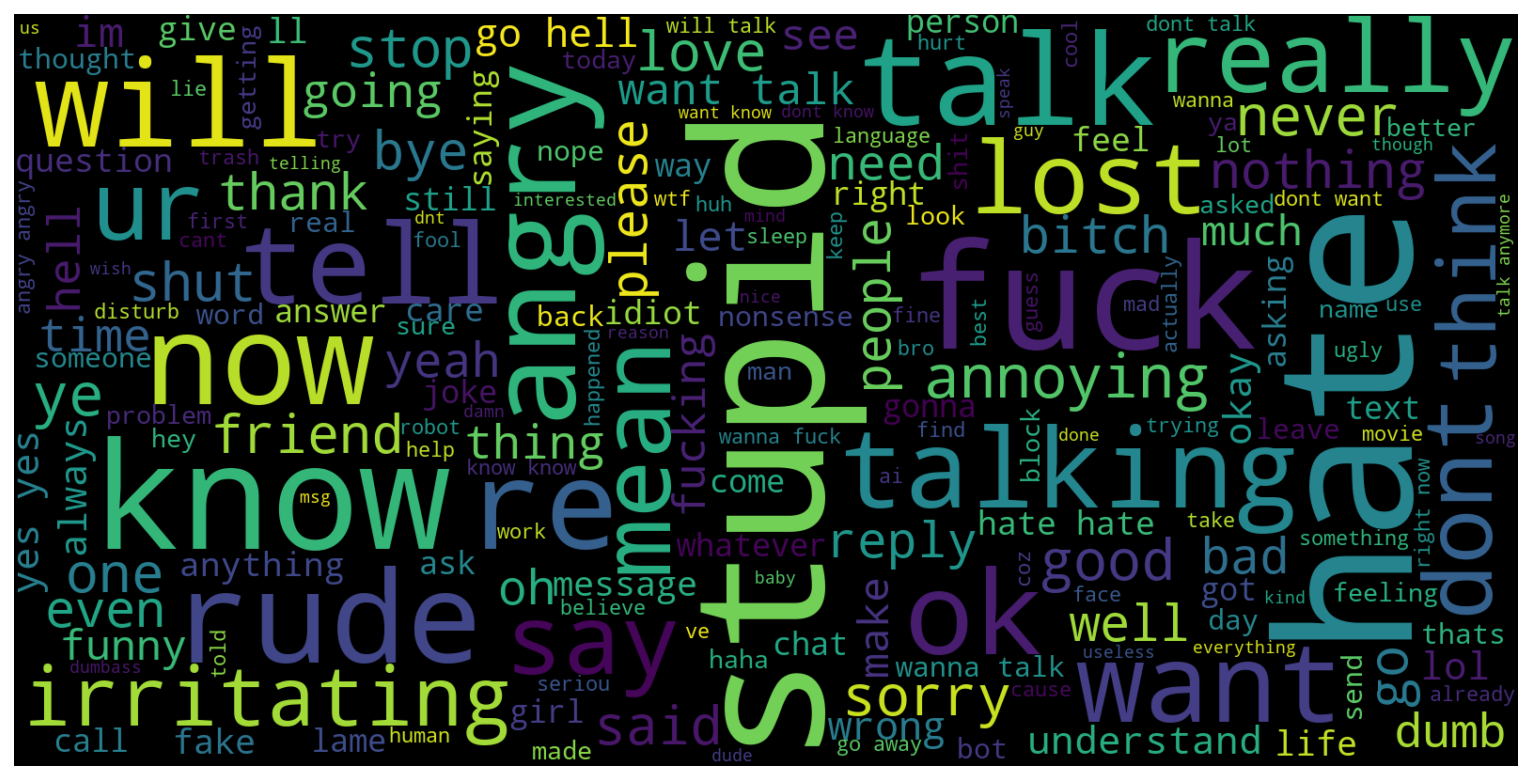

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(anger_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
sad_tweets = train_clean_df[train_clean_df.label == 2]
sad_string = []
for i in sad_tweets.index:
    sad_string.append(str(sad_tweets['turn1'][i] + ' ' +sad_tweets['turn2'][i] + ' ' + sad_tweets['turn3'][i]))
sad_string = pd.Series(sad_string).str.cat(sep=' ')

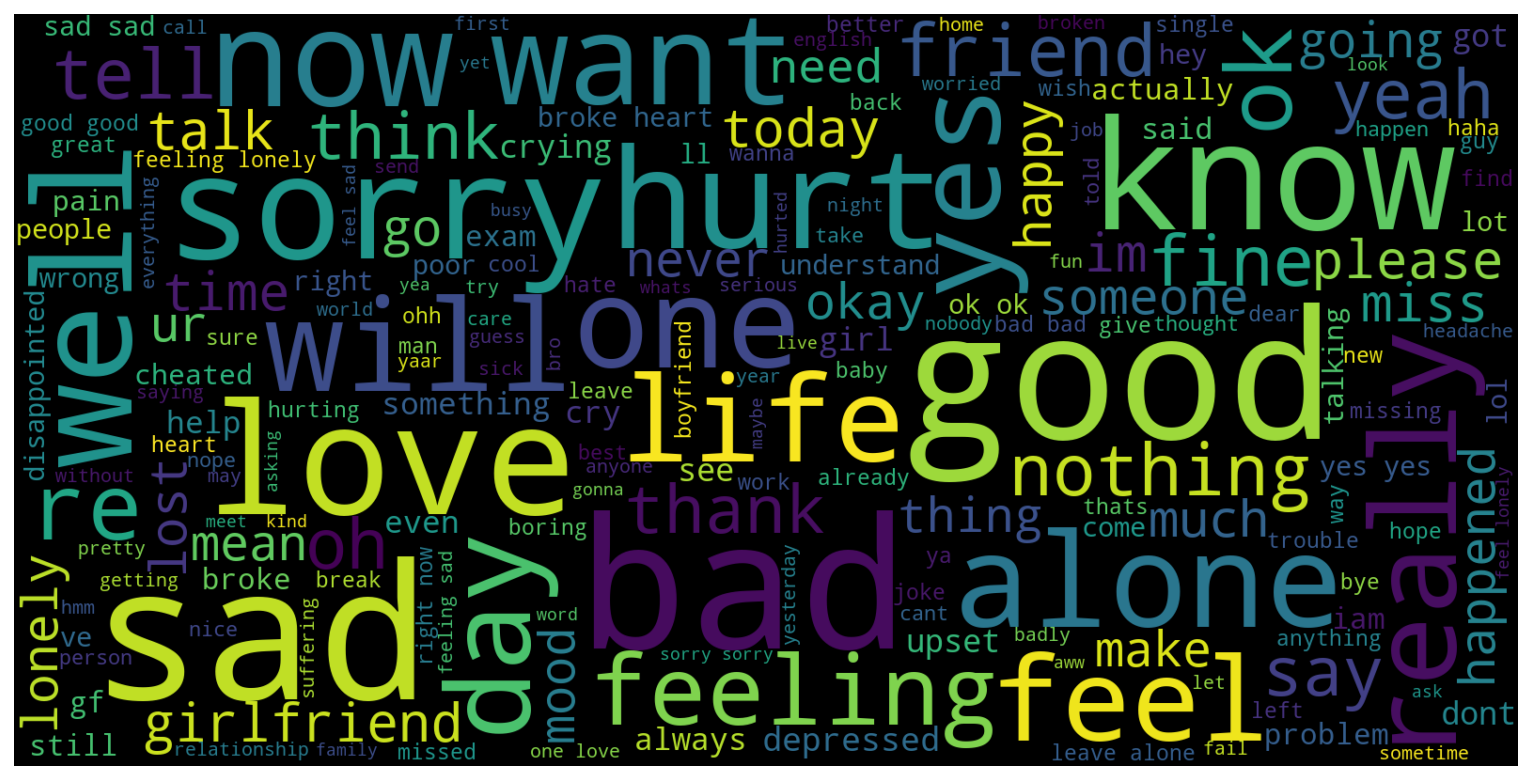

In [ ]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(sad_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
happy_tweets = train_clean_df[train_clean_df.label == 1]
happy_string = []
for i in happy_tweets.index:
    happy_string.append(str(happy_tweets['turn1'][i] + ' ' +happy_tweets['turn2'][i] + ' ' + happy_tweets['turn3'][i]))
happy_string = pd.Series(happy_string).str.cat(sep=' ')

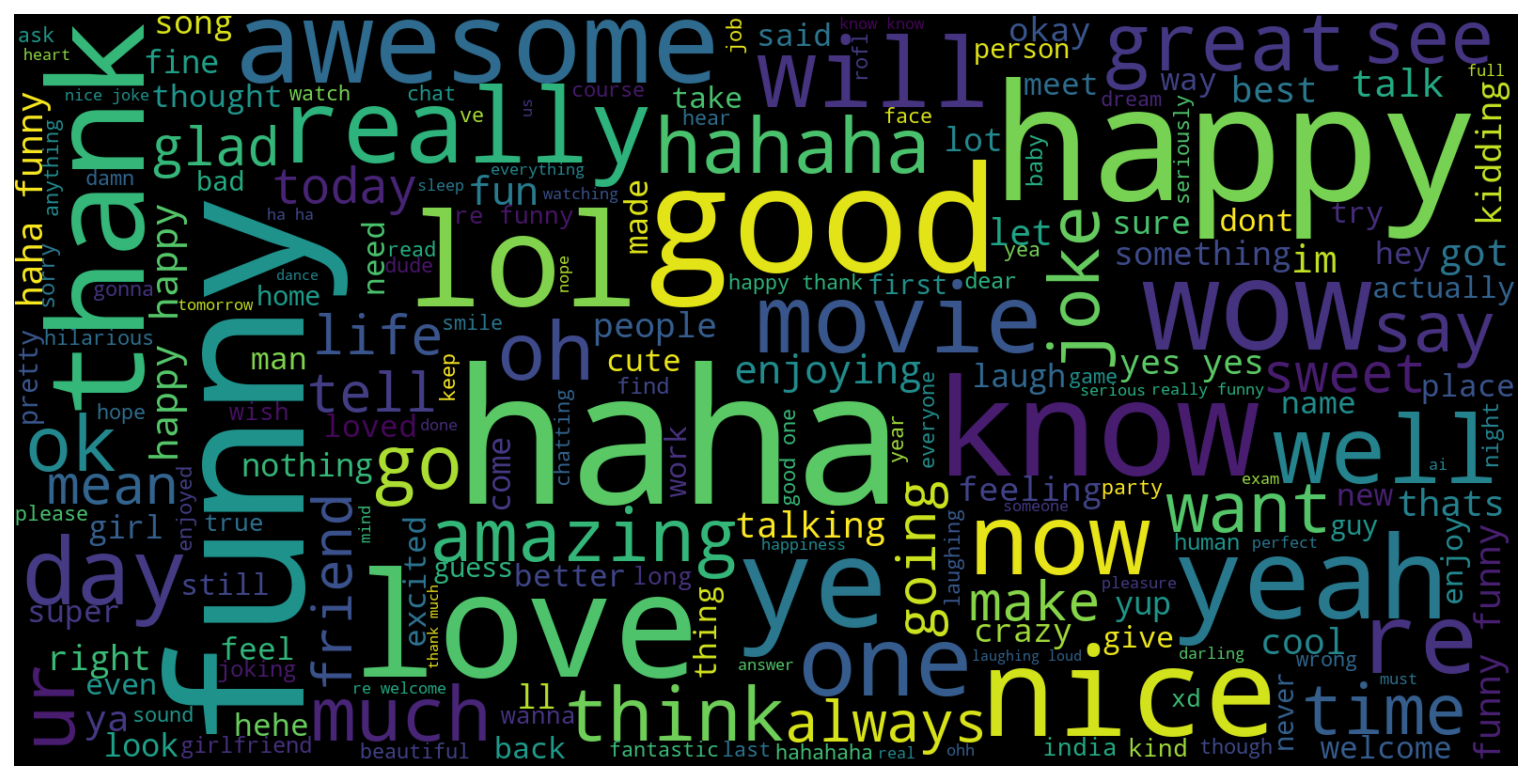

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(happy_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
others_tweets = train_clean_df[train_clean_df.label == 0]
others_string = []
for i in others_tweets.index:
    others_string.append(str(others_tweets['turn1'][i] + ' ' +others_tweets['turn2'][i] + ' ' + others_tweets['turn3'][i]))
others_string = pd.Series(others_string).str.cat(sep=' ')

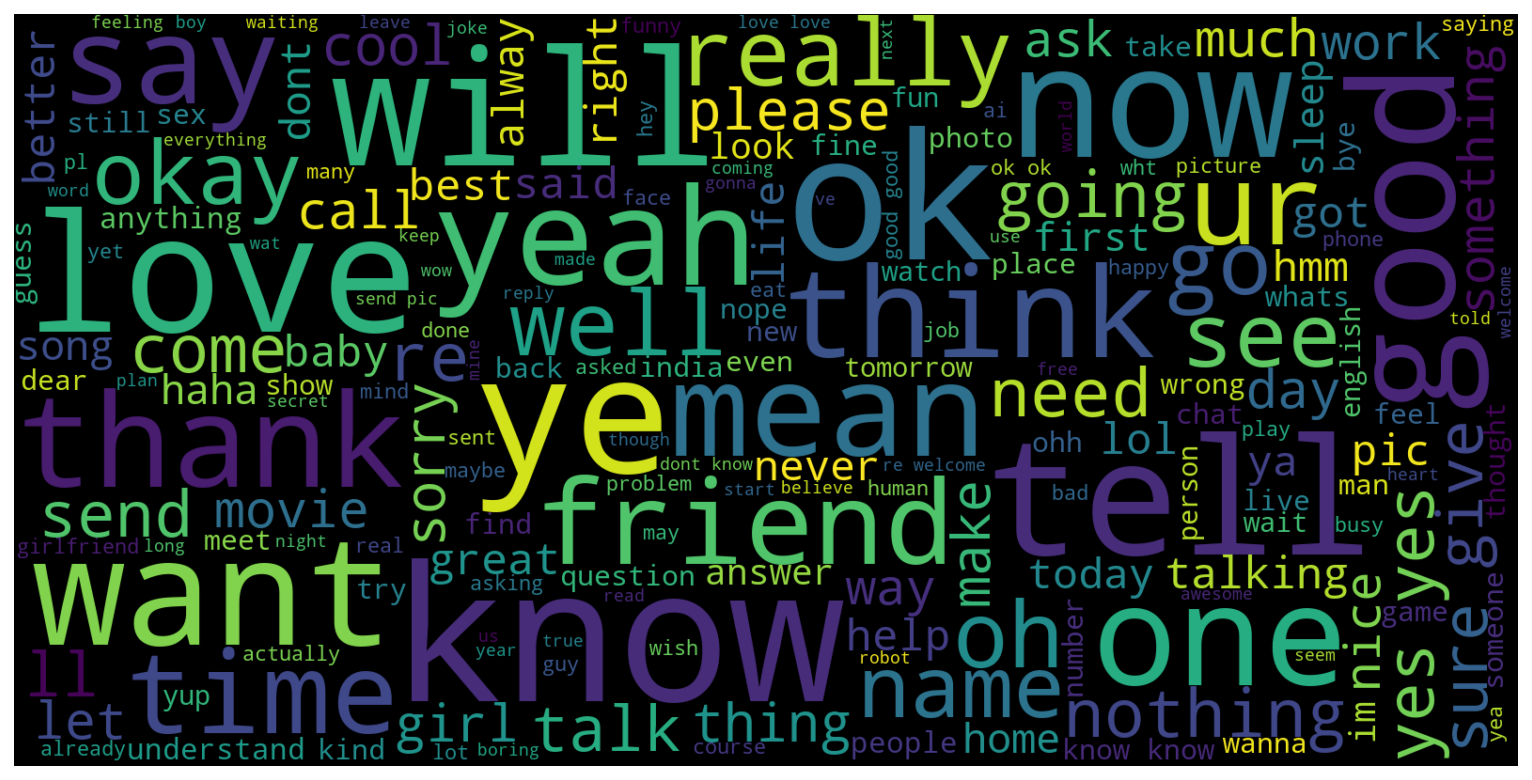

In [ ]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(others_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In order for me to implement a couple of data visualisation in the next step, I need term frequency data.
What kind of words are used in the tweets, and how many times it is used in entire corpus.
I used count vectorizer to calculate the term frequencies, the count vectorizer is also for fit, train and predict,
but at this stage, I will just be extracting the term frequencies for the visualisation.

There are parameter options available for count vectorizer, such as removing stop words, limiting the maximum number of terms.
However, in order to get a full picture of the dataset first, I implemented with stop words included, and not limiting the maximum number of terms.

In [ ]:
trainDataPath = '/content/drive/My Drive/ML CLASS PROJECT/emocontext/train.txt'

testDataPath = '/content/drive/My Drive/ML CLASS PROJECT/emocontext/dev.txt'

gloveDir = '/content/drive/My Drive/glove/'

EMBEDDING_DIM = 100                 # To set the dimension of  word embedding
MAX_NB_WORDS = 20000                # To set the upper limit on the number of tokens extracted using keras.preprocessing.text.Tokenizer 

In [ ]:
def preprocessData(dataFilePath):
    """Load data from a file, process and return indices, conversations and labels in separate lists
    Input:
        dataFilePath : Path to train/test file to be processed
        mode : "train" mode returns labels. "test" mode doesn't return labels.
    Output:
        indices : Unique conversation ID list
        conversations : List of 3 turn conversations, processed and each turn separated by the <eos> tag
        labels : [Only available in "train" mode] List of labels
    """
    indices = []
    conversations = []
    labels = []
    with io.open(dataFilePath, encoding="utf8") as finput:
        finput.readline()
        for line in finput:
            # Convert multiple instances of . ? ! , to single instance
            # okay...sure -> okay . sure
            # okay???sure -> okay ? sure
            # Add whitespace around such punctuation
            # okay!sure -> data = pad_sequences(trainSequences, maxlen=MAX_SEQUENCE_LENGTH)
            repeatedChars = ['.', '?', '!', ',']
            for c in repeatedChars:
                lineSplit = line.split(c)
                while True:
                    try:
                        lineSplit.remove('')
                    except:
                        break
                cSpace = ' ' + c + ' '    
                line = cSpace.join(lineSplit)
            
            line = line.strip().split('\t')
            #if mode == "train":
                # Train data contains id, 3 turns and label
            label = emotion2label[line[4]]
            labels.append(label)
            
            conv = ' <eos> '.join(line[1:4])
            
            # Remove any duplicate spaces
            duplicateSpacePattern = re.compile(r'\ +')
            conv = re.sub(duplicateSpacePattern, ' ', conv)
            
            indices.append(int(line[0]))
            conversations.append(conv.lower())
    
    
    return indices, conversations, labels
    
        

In [ ]:
def getEmbeddingMatrix(wordIndex):
    """Populate an embedding matrix using a word-index. If the word "happy" has an index 19,
       the 19th row in the embedding matrix should contain the embedding vector for the word "happy".
    Input:
        wordIndex : A dictionary of (word : index) pairs, extracted using a tokeniser
    Output:
        embeddingMatrix : A matrix where every row has 100 dimensional GloVe embedding
    """
    embeddingsIndex = {}
    # Load the embedding vectors from ther GloVe file
    with io.open(os.path.join(gloveDir, 'glove.6B.100d.txt'), encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            embeddingVector = np.asarray(values[1:], dtype='float32')
            embeddingsIndex[word] = embeddingVector
    
    print('Found %s word vectors.' % len(embeddingsIndex))
    
    # Minimum word index of any word is 1. 
    embeddingMatrix = np.zeros((len(wordIndex) + 1, EMBEDDING_DIM))
    for word, i in wordIndex.items():
        embeddingVector = embeddingsIndex.get(word)
        if embeddingVector is not None:
            # words not found in embedding index will be all-zeros.
            embeddingMatrix[i] = embeddingVector
    
    return embeddingMatrix

In [ ]:
    from keras.preprocessing.text import Tokenizer
    import io
    import os
    
    print("Processing training data...")
    trainIndices, trainTexts, labels = preprocessData(trainDataPath)

    print("Processing test data...")
    testIndices, testTexts, y_test = preprocessData(testDataPath)
    
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(trainTexts)
    trainSequences = tokenizer.texts_to_sequences(trainTexts)
    testSequences = tokenizer.texts_to_sequences(testTexts)

    wordIndex = tokenizer.word_index
    print("Found %s unique tokens." % len(wordIndex))

    print("Populating embedding matrix...")
    embeddingMatrix = getEmbeddingMatrix(wordIndex)

Processing training data...
Processing test data...
Found 16831 unique tokens.
Populating embedding matrix...
Found 400000 word vectors.


In [ ]:
def transform(x):
  global embeddingMatrix
  
  xnew=[]
  for wordi in x: 
    xnew.append(embeddingMatrix[wordi])
  return xnew

In [ ]:

transformer = FunctionTransformer(transform)
trainSequences_ = transformer.transform(trainSequences)

In [ ]:
testSequences_ = transformer.transform(testSequences)

In [ ]:
data = pad_sequences(trainSequences_, maxlen=100)
labels = np.asarray(labels)

In [ ]:
test_data = pad_sequences(testSequences_,maxlen = 100)
y_test = np.asarray(y_test)

In [ ]:
data.shape

(30160, 100, 100)

In [ ]:
data_new = np.sum(data,axis = 1)/100


In [ ]:
test_data_new = np.sum(test_data,axis = 1)/100

In [ ]:
data_new

array([[-0.01, -0.01,  0.01, ..., -0.02,  0.03,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.02,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.04,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.01, ..., -0.03,  0.03,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.02,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.04,  0.  ]])

In [ ]:
#Creating parameter grid of differnt values we want to try oue model on
param_svm={'alpha':[0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
param_rf={'n_estimators':[100,200,500,1000,2000],'max_depth':[5, 10]}
param_knn={'n_neighbors':[5, 11, 15, 21, 31, 41, 51, 99]}

In [ ]:
#preparing a dictionary of 3 classifiers

classifiers={
    
    "Gaussian Naive Bayes":GaussianNB(),        
    "Support Vector Machine":SGDClassifier( class_weight='balanced',penalty='l2', loss='hinge', random_state=42),
    "Random Forest":RandomForestClassifier(criterion='gini', random_state=42, n_jobs=-1),
    
}

In [ ]:



for i,(clf_name,clf) in enumerate(classifiers.items()):
    
    if clf_name=='Gaussian Naive Bayes':
        gs_clf = GridSearchCV(clf,{},scoring='f1_weighted')  
        gs_clf.fit(data_new,labels)
        print(clf_name.upper())
        print()
        print('Cross-Validation Weighted Average of f1 : ',gs_clf.best_score_)   
    elif clf_name=='Support Vector Machine':
        gs_clf = GridSearchCV(clf,param_svm,scoring='f1_weighted')
        gs_clf.fit(data_new,labels)
        print(clf_name.upper())
        print()
        print('Cross-Validation Weighted Average of f1 : ',gs_clf.best_score_) 
    else: 
        gs_clf = GridSearchCV(clf,param_rf,scoring='f1_weighted')
        gs_clf.fit(data_new,labels)
        print(clf_name.upper())
        print()
        print('Cross-Validation Weighted Average of f1 : ',gs_clf.best_score_)   
    
    y_pred = gs_clf.predict(test_data_new)
    print("Classification report :")
    print(classification_report(y_test,y_pred))
    

GAUSSIAN NAIVE BAYES

Cross-Validation Weighted Average of f1 :  0.4229001481651693
Classification report :
              precision    recall  f1-score   support

           0       0.92      0.36      0.51      2338
           1       0.12      0.39      0.19       142
           2       0.08      0.62      0.14       125
           3       0.16      0.42      0.23       150

    accuracy                           0.37      2755
   macro avg       0.32      0.45      0.27      2755
weighted avg       0.80      0.37      0.46      2755

SUPPORT VECTOR MACHINE

Cross-Validation Weighted Average of f1 :  0.5604226998563038
Classification report :
              precision    recall  f1-score   support

           0       0.93      0.59      0.72      2338
           1       0.13      0.42      0.20       142
           2       0.18      0.49      0.26       125
           3       0.23      0.67      0.34       150

    accuracy                           0.58      2755
   macro avg       0.